In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

#### New Update March 12

In [2]:
def calculate_metrics(ref, calculated, tol_type="abs", tolerance=5, mode = "one"):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Now, 'calculated' is a list of tuples, each containing two candidate BPM values.
    For each index, we select the candidate BPM that is closest to the ground truth.
    
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (list of tuple): Each tuple contains two candidate BPMs.
        tol_type (str): "abs" or "rel" tolerance type.
        tolerance (float): Tolerance value.
        
    Returns:
        dict: Dictionary with accuracy and error metrics.
    """
    # Determine the tolerance for comparison
    if tol_type == "rel":
        ref_tolerance = ref * (tolerance / 100)
    elif tol_type == "abs":
        ref_tolerance = tolerance

    if mode == "many":
        # For each index, choose the candidate BPM that minimizes the error from ref[i]
        chosen = np.array([
            min(cand, key=lambda bpm: abs(bpm - ref[i]))
            for i, cand in enumerate(calculated)
        ])
    
    elif mode == "one":
        chosen = calculated
    
    # Compute accuracy metrics using the chosen BPMs
    acc1_count = np.sum(np.abs(chosen - ref) <= ref_tolerance)
    acc2_count = np.sum(
        (np.abs(chosen - ref) <= ref_tolerance) |
        (np.abs(chosen - 2 * ref) <= ref_tolerance) |
        (np.abs(chosen - ref / 2) <= ref_tolerance)
    )
    
    scales = [1, 2, 0.5, 3, 1/3]
    acc3_count = np.sum(np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0))
    
    hits_idx = np.where(np.abs(chosen - ref) <= ref_tolerance)[0]
    hits_dbl_idx = np.where(np.abs(chosen - 2 * ref) <= ref_tolerance)[0]
    hits_hf_idx = np.where(np.abs(chosen - ref / 2) <= ref_tolerance)[0]
    
    bpm_hits_idx = chosen[hits_idx]
    bpm_hits_dbl_idx = chosen[hits_dbl_idx]
    bpm_hits_hf_idx = chosen[hits_hf_idx]
    
    base_tempo = ref[hits_idx]
    
    # Overestimated errors:
    oe1_count = np.sum(
        (chosen > ref) &
        ~np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    oe2_count = np.sum(
        (chosen > ref) &
        np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    
    total = len(ref)
    
    metrics = {
        "acc1": (acc1_count / total) * 100,
        "acc2": (acc2_count / total) * 100,
        "acc3": (acc3_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
        "base_tempo": base_tempo,
        "hits_idx": hits_idx,
        "hits_dbl_idx": hits_dbl_idx,
        "hits_hf_idx": hits_hf_idx,
        "bpm_hits_idx": bpm_hits_idx,
        "bpm_hits_dbl_idx": bpm_hits_dbl_idx,
        "bpm_hits_hf_idx": bpm_hits_hf_idx
    }
    return metrics

#### Multi bpm

In [ ]:
def estimate_tempo_pair(a, b, mode ):

    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # bpm_pair1 35 % | bpm_pair2 55%
        ("both_hand_y", "both_foot_y"),                     # bpm_pair1 70 % | bpm_pair2 81%
        ("both_hand_resultant", "both_foot_resultant"),     # bpm_pair1 49 % | bpm_pair2 66%
        ("bothhand_xy", "bothfoot_xy"),                     # bpm_pair1 55 % | bpm_pair2 68%
        ]

    json_data = {"both_hand_foot_x": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_y": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_resultant": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, 
                 "both_hand_foot_xy": {"bpm_pair": None, "bpm_quad": None, "Acc1_bpm_pair": None, "Acc1_bpm_quad": None}, }
    
    for hnd, ft in segment_pairs:

        read_file1 = f"./one_sensor/tempo_{a}_{b}/pos/{hnd}_{mode}_{a}_{b}.pkl"
        read_file2 = f"./one_sensor/tempo_{a}_{b}/pos/{ft}_{mode}_{a}_{b}.pkl"

        read_file3 = f"./one_sensor/tempo_{a}_{b}/vel/{hnd}_{mode}_{a}_{b}.pkl"
        read_file4 = f"./one_sensor/tempo_{a}_{b}/vel/{ft}_{mode}_{a}_{b}.pkl"

        df1 = pd.read_pickle(read_file1)
        df2 = pd.read_pickle(read_file2)
        df3 = pd.read_pickle(read_file3)
        df4 = pd.read_pickle(read_file4)

        bpm_pair = []
        bpm_quad = []
        for n in range(df1.shape[0]):
            bpm1 = df1.iloc[n]["bpm_median"]    # hand bpm
            bpm2 = df2.iloc[n]["bpm_median"]    # foot bpm
            
            bpm3 = df3.iloc[n]["bpm_median"]    # hand bpm
            bpm4 = df4.iloc[n]["bpm_median"]    # foot bpm
            
            bpm_pair.append((bpm1, bpm2))
            bpm_quad.append((bpm1, bpm2, bpm3, bpm4))
            
        ref = df1["music_tempo"].to_numpy()
        
        metrics1 = calculate_metrics(ref, bpm_pair, tol_type = "rel", tolerance = 6, mode = "many")
        metrics2 = calculate_metrics(ref, bpm_quad, tol_type = "rel", tolerance = 6, mode = "many")
        
        print(f"{hnd} | {ft}:", round(metrics1["acc1"]), round(metrics2["acc1"]))
    
    return    

tempo_cases = {
    
}


both_hand_x | both_foot_x: 35 55
both_hand_y | both_foot_y: 70 82
both_hand_resultant | both_foot_resultant: 49 67
bothhand_xy | bothfoot_xy: 55 69


### One bpm

In [ ]:
segment_keys = [
                "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                "bothhand_xy", "bothfoot_xy","both_hand_resultant", "both_foot_resultant",
                
                "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
               
                "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                 
                "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                ] 

for idx, f_name in enumerate(segment_keys):
    f_path = f"./one_sensor/tempo_{a}_{b}/pos/{f_name}_{mode}_{a}_{b}.pkl"
    df_ax = pd.read_pickle(f_path)
    
    ref = df_ax["music_tempo"].to_numpy()
    metrics = calculate_metrics(ref, np.asarray(df_ax["bpm_median"]), tol_type = "rel", tolerance = 6, mode = "one")
    print(f"{f_name}:", round(metrics["acc1"]))
    
    if (idx+1)%4 == 0:
        print("\n")

### Plot Tempo Cases

In [16]:
def estimate_tempo_pair(a, b, mode, w_sec, h_sec):
    # Define the segment pairs to process
    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # Example: bpm_pair ~35%, bpm_quad ~55%
        ("both_hand_y", "both_foot_y"),                     # Example: bpm_pair ~70%, bpm_quad ~81%
        ("both_hand_resultant", "both_foot_resultant"),     # Example: bpm_pair ~49%, bpm_quad ~66%
        ("bothhand_xy", "bothfoot_xy"),                     # Example: bpm_pair ~55%, bpm_quad ~68%
    ]
    
    # Prepare a dictionary to hold results for each segment pair
    json_data = {}
    
    for hnd, ft in segment_pairs:
        # Build file paths for position and velocity data
        read_file1 = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file2 = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file3 = f"./saved_result/tempo_cases/tempo_{a}_{b}/vel/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        read_file4 = f"./saved_result/tempo_cases/tempo_{a}_{b}/vel/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        
        # Load the dataframes
        df1 = pd.read_pickle(read_file1)
        df2 = pd.read_pickle(read_file2)
        df3 = pd.read_pickle(read_file3)
        df4 = pd.read_pickle(read_file4)
        
        # Build candidate BPM pairs (for positions) and quads (for positions and velocities)
        bpm_pair = []
        bpm_quad = []
        for n in range(df1.shape[0]):
            bpm1 = df1.iloc[n]["bpm_median"]   # hand (position)
            bpm2 = df2.iloc[n]["bpm_median"]   # foot (position)
            bpm3 = df3.iloc[n]["bpm_median"]   # hand (velocity)
            bpm4 = df4.iloc[n]["bpm_median"]   # foot (velocity)
            bpm_pair.append((bpm1, bpm2))
            bpm_quad.append((bpm1, bpm2, bpm3, bpm4))
        
        # Use music_tempo from df1 as the reference tempo array.
        ref = df1["music_tempo"].to_numpy()
        
        # Calculate metrics for the candidate pairs and quads
        metrics1 = calculate_metrics(ref, bpm_pair, tol_type="rel", tolerance=6, mode = "many")
        metrics2 = calculate_metrics(ref, bpm_quad, tol_type="rel", tolerance=6, mode = "many")
        
        # For clarity, build a key for the current segment pair
        pair_key = f"{hnd}_{ft}"
        
        # Print the Acc1 results for each candidate method
        # print(f"{pair_key}: Acc1 pair = {round(metrics1['acc1'])}%, Acc1 quad = {round(metrics2['acc1'])}%")
        
        # Store the candidate BPMs and accuracy metrics in json_data
        json_data[pair_key] = {
            "bpm_pair": bpm_pair,
            "bpm_quad": bpm_quad,
            "Acc1_bpm_pair": metrics1["acc1"],
            "Acc1_bpm_quad": metrics2["acc1"]
        }
    
    return json_data

pair_keys = ['both_hand_x_both_foot_x', 'both_hand_y_both_foot_y', 
             'both_hand_resultant_both_foot_resultant', 'bothhand_xy_bothfoot_xy']
a = 60; b= [100,110,120,130,140,150,160,170,180,190,200]
mode = "zero_uni"
w_sec = 5
h_sec = w_sec/2

tcase_data= {key: {"Acc1_bpm_pair": [], "Acc1_bpm_quad": [],}
            for key in pair_keys}

for bi in b:
    jdata = estimate_tempo_pair(a, bi, mode, w_sec, h_sec)
    
    for ky, itm in jdata.items():
         
        tcase_data[ky]["Acc1_bpm_pair"].append(itm["Acc1_bpm_pair"])
        tcase_data[ky]["Acc1_bpm_quad"].append(itm["Acc1_bpm_quad"])
        

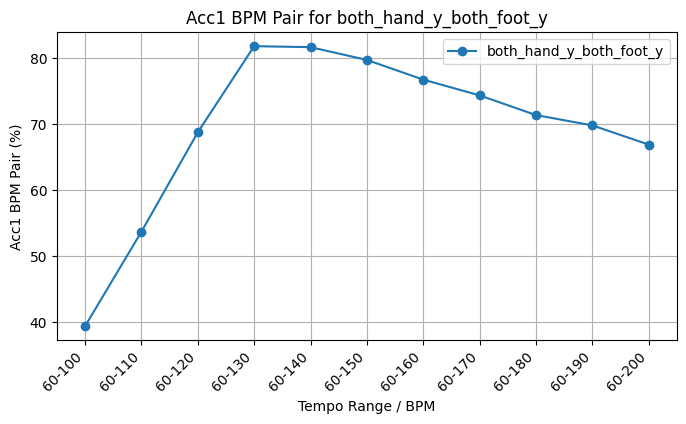

In [18]:
xaxis = ["60-100", "60-110", "60-120", "60-130", "60-140", "60-150", "60-160", "60-170", "60-180", "60-190", "60-200"]
x_positions = np.arange(1, len(xaxis)+1)

def plot_acc1_for_key(key, x_positions, xaxis, tcase_data):
    ydata = tcase_data[key]["Acc1_bpm_quad"]
    plt.figure(figsize=(8, 4))
    plt.plot(x_positions, ydata, marker='o', label=key)
    plt.xlabel("Tempo Range / BPM")
    plt.ylabel("Acc1 BPM Pair (%)")
    plt.title(f"Acc1 BPM Pair for {key}")
    plt.xticks(x_positions, xaxis, rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.show()

# For example, to plot for one key:
key_to_plot = list(tcase_data.keys())[1]  # or any key from your dictionary
plot_acc1_for_key(key_to_plot, x_positions, xaxis, tcase_data)



### Tempo cases Single

In [ ]:
def estimate_tempo_one(a, b, mode, w_sec, h_sec):

    segment_keys = [
                    "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                    "bothhand_xy", "bothfoot_xy","both_hand_resultant", "both_foot_resultant",
                    
                    "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
                
                    "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                    "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                    
                    "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                    ] 

    json_data = {}
    for idx, f_name in enumerate(segment_keys):
        f_path = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
        df_ax = pd.read_pickle(f_path)
        
        ref = df_ax["music_tempo"].to_numpy()
        metrics = calculate_metrics(ref, np.asarray(df_ax["bpm_median"]), tol_type = "rel", tolerance = 6, mode = "one")
        
        json_data[f_name] = {
            "Acc1_bpm_one": metrics["acc1"],
        }
    
    return json_data

In [5]:
segment_keys = [
                "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                "bothhand_xy", "bothfoot_xy","both_hand_resultant", "both_foot_resultant",
                
                "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
               
                "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                 
                "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                ] 

a = 60; b= [100,110,120,130,140,150,160,170,180,190,200]
mode = "zero_uni"
w_sec = 5
h_sec = w_sec/2

tcase_data_one= {key: {"Acc1_bpm_one": [],}
            for key in segment_keys}

for bi in b:
    jdata = estimate_tempo_one(a, bi, mode, w_sec, h_sec)
    
    for ky, itm in jdata.items():
        tcase_data_one[ky]["Acc1_bpm_one"].append(itm["Acc1_bpm_one"])

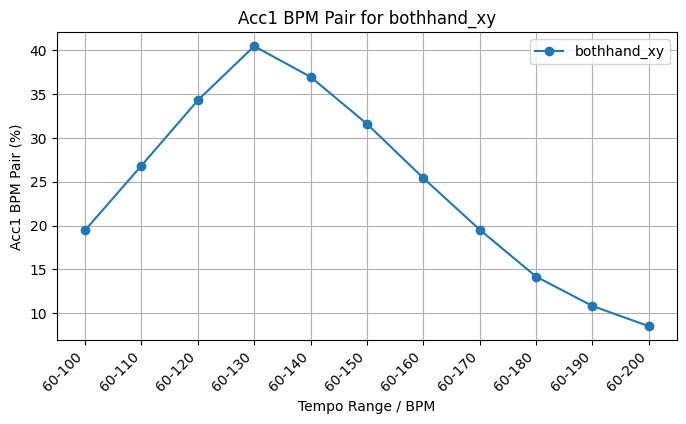

In [20]:
xaxis = ["60-100", "60-110", "60-120", "60-130", "60-140", "60-150", "60-160", "60-170", "60-180", "60-190", "60-200"]
x_positions = np.arange(1, len(xaxis)+1)

def plot_acc1_for_key(key, x_positions, xaxis, tcase_data_one):
    ydata = tcase_data_one[key]["Acc1_bpm_one"]
    plt.figure(figsize=(8, 4))
    plt.plot(x_positions, ydata, marker='o', label=key)
    plt.xlabel("Tempo Range / BPM")
    plt.ylabel("Acc1 BPM Pair (%)")
    plt.title(f"Acc1 BPM Pair for {key}")
    plt.xticks(x_positions, xaxis, rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.show()

# For example, to plot for one key:
key_to_plot = 'bothhand_xy'  # or any key from your dictionary
plot_acc1_for_key(key_to_plot, x_positions, xaxis, tcase_data_one)